# Modely by Topic

Here an attempt is made to fit a model for one topic and test it on the 4 other topics. This can reveal similarities between text from different topics.

The hyperparameters will not be optimized again, as this is not the main part of the research, but will be taken from previous optimization.

##  Load train and test data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Provide the correct file path
file_path_train = "/content/drive/My Drive/BA THESIS/data/train_NB_lem.csv"
#file_path_val = "/content/drive/My Drive/BA THESIS/data/val_NB_lem.csv"
file_path_test = "/content/drive/My Drive/BA THESIS/data/test_NB_lem.csv"


# Load CSV
train_NB_lem = pd.read_csv(file_path_train)
#val_NB_lem = pd.read_csv(file_path_val)
test_NB_lem = pd.read_csv(file_path_test)

In [4]:
# Provide the correct file path
file_path_train = "/content/drive/My Drive/BA THESIS/data/train_BERT.csv"
#file_path_val = "/content/drive/My Drive/BA THESIS/data/val_BERT.csv"
file_path_test = "/content/drive/My Drive/BA THESIS/data/test_BERT.csv"


# Load CSV
train_BERT = pd.read_csv(file_path_train)
#val_BERT = pd.read_csv(file_path_val)
test_BERT = pd.read_csv(file_path_test)

## Fitting models

We fit a naive BAyes and a BERT model on each subset of the training data by topic and run a prediciton for test data.

In [15]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [16]:
# function to fit a models on a given subset and then run the classification and return the classification

def NB_on_subset (topic):

  #tarining:
  train_data = train_NB_lem[train_NB_lem['topic'] == topic]
  x = train_data['text']
  y = train_data['ground_truth']

  vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
  X_train_count = vectorizer.fit_transform(x)

  nb = MultinomialNB(alpha = 1)
  nb.fit(X_train_count, y)

  # testing
  x_test = vectorizer.transform(test_NB_lem['text'])
  y_test = test_NB_lem['ground_truth']
  y_pred = nb.predict(x_test)

  return y_pred

In [17]:
nb_finance_preds = NB_on_subset("finance")

In [18]:
nb_news_preds = NB_on_subset("news")

In [19]:
nb_reddit_pred = NB_on_subset("reddit")

In [20]:
nb_twitter_preds = NB_on_subset("twitter")

In [21]:
nb_movie_preds = NB_on_subset("movie")

In [5]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from sklearn.metrics import f1_score


In [6]:
# function to fit a models on a given subset and then run the classification and return the classification

def BERT_on_subset (topic):

  train_data = train_BERT[train_BERT['topic'] == topic]
  test_data = test_BERT.copy()

  # encode labels
  label_encoder = LabelEncoder()
  train_data["label"] = label_encoder.fit_transform(train_data["ground_truth"])
  test_data["label"] = label_encoder.transform(test_data["ground_truth"])

  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

  def tokenize_function(text):
    return tokenizer(
        text,
        truncation=True,
        padding="longest",    # or use "longest" for dynamic padding
        max_length=200,       # since we are using headlines
        return_tensors="tf"
    )

  # Tokenize texts and extract tensors
  tokenized_train = tokenize_function(train_data["text"].tolist())
  tokenized_test = tokenize_function(test_data["text"].tolist())

  # Convert labels to a TensorFlow tensor
  labels_train = tf.convert_to_tensor(train_data["label"].tolist())
  labels_test = tf.convert_to_tensor(test_data["label"].tolist())

  # Create a dataset from the dictionary and labels
  dataset_train = tf.data.Dataset.from_tensor_slices((
      {
          "input_ids": tokenized_train["input_ids"],
          "attention_mask": tokenized_train["attention_mask"]
      },
      labels_train
  ))

  dataset_test = tf.data.Dataset.from_tensor_slices((
      {
          "input_ids": tokenized_test["input_ids"],
          "attention_mask": tokenized_test["attention_mask"]
      },
      labels_test
  ))

  batch_size = 16
  dataset_train = dataset_train.shuffle(buffer_size=len(train_BERT)).batch(batch_size)

  model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

  # Compile the model with an optimizer, loss, and metrics
  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  num_epochs = 3
  history = model.fit(
      dataset_train,
#      validation_data=dataset_val,
      epochs=num_epochs
  )

  # testing

  logits = model.predict(tokenized_test).logits

  # Convert logits to class predictions
  y_pred_bert = tf.argmax(logits, axis=-1).numpy()

  label_map = {0: "negative", 1: "neutral", 2: "positive"}
  predicted_labels_bert = [label_map[pred] for pred in y_pred_bert]

  return predicted_labels_bert

In [10]:
bert_finance_preds = BERT_on_subset("finance")

<ipython-input-6-ff97fb66f7e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["label"] = label_encoder.fit_transform(train_data["ground_truth"])
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
78/78 [==============================] - 47s 113ms/step - loss: 0.9412 - accuracy: 0.5416
Epoch 2/3
78/78 [==============================] - 7s 85ms/step - loss: 0.5578 - accuracy: 0.7805
Epoch 3/3
153/153 [==============================] - 8s 34ms/step


In [11]:
bert_news_preds = BERT_on_subset("news")

<ipython-input-6-ff97fb66f7e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["label"] = label_encoder.fit_transform(train_data["ground_truth"])
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
203/203 [==============================] - 53s 72ms/step - loss: 0.9345 - accuracy: 0.5580
Epoch 2/3
203/203 [==============================] - 12s 58ms/step - loss: 0.6296 - accuracy: 0.7548
Epoch 3/3
153/153 [==============================] - 8s 34ms/step


In [12]:
bert_reddit_preds = BERT_on_subset("reddit")

<ipython-input-6-ff97fb66f7e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["label"] = label_encoder.fit_transform(train_data["ground_truth"])
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
262/262 [==============================] - 64s 97ms/step - loss: 0.8093 - accuracy: 0.6262
Epoch 2/3
262/262 [==============================] - 18s 68ms/step - loss: 0.4427 - accuracy: 0.8372
Epoch 3/3
153/153 [==============================] - 8s 34ms/step


In [13]:
bert_twitter_preds = BERT_on_subset("twitter")

<ipython-input-6-ff97fb66f7e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["label"] = label_encoder.fit_transform(train_data["ground_truth"])
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
263/263 [==============================] - 64s 97ms/step - loss: 0.9060 - accuracy: 0.5649
Epoch 2/3
263/263 [==============================] - 18s 67ms/step - loss: 0.5077 - accuracy: 0.8145
Epoch 3/3
153/153 [==============================] - 8s 34ms/step


In [14]:
bert_movie_preds = BERT_on_subset("movie")

<ipython-input-6-ff97fb66f7e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["label"] = label_encoder.fit_transform(train_data["ground_truth"])
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
262/262 [==============================] - 59s 79ms/step - loss: 0.6484 - accuracy: 0.7424
Epoch 2/3
262/262 [==============================] - 15s 57ms/step - loss: 0.3767 - accuracy: 0.8716
Epoch 3/3
153/153 [==============================] - 8s 34ms/step


In [26]:
# create a data frame with all predictions

all_preds_subsets = pd.DataFrame({
    'Text': test_BERT['text'],
    'Topic': test_NB_lem['topic'],
    'Actual': test_NB_lem['ground_truth'],
    'NB_finance': nb_finance_preds,
    'BERT_finance': bert_finance_preds,
    'NB_news': nb_news_preds,
    'BERT_news': bert_news_preds,
    'NB_reddit': nb_reddit_pred,
    'BERT_reddit': bert_reddit_preds,
    'NB_twitter': nb_twitter_preds,
    'BERT_twitter': bert_twitter_preds,
    'NB_movie': nb_movie_preds,
    'BERT_movie': bert_movie_preds
})


In [27]:
all_preds_subsets

,Text,Topic,Actual,NB_finance,BERT_finance,NB_news,BERT_news,NB_reddit,BERT_reddit,NB_twitter,BERT_twitter,NB_movie,BERT_movie
0,catalog every bodily fluids gag something mary,movie,neutral,negative,neutral,negative,positive,negative,neutral,negative,neutral,neutral,negative
1,incredibly flexible cast,movie,positive,negative,positive,neutral,positive,negative,positive,neutral,negative,positive,positive
2,shameful statement aap sanjay singh downgrade ...,twitter,neutral,negative,negative,neutral,negative,negative,neutral,neutral,neutral,neutral,negative
3,name hindu terrorist spread hates modi govt ac...,twitter,neutral,neutral,positive,positive,negative,negative,neutral,negative,neutral,negative,negative
4,send modi shah pakistan,twitter,neutral,neutral,neutral,neutral,positive,positive,neutral,neutral,neutral,negative,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865,hamstrung badly handled screenplay really amus...,movie,negative,negative,negative,neutral,negative,positive,negative,negative,negative,negative,negative
4866,understand means say hope people make right de...,reddit,negative,neutral,negative,neutral,negative,negative,negative,negative,negative,negative,neutral
4867,imf launch global public private borrowing dat...,news,positive,neutral,positive,positive,positive,negative,neutral,positive,neutral,neutral,neutral
4868,brilliant read extortion racket amit shah ran,reddit,positive,neutral,positive,positive,positive,positive,positive,neutral,positive,positive,positive


In [28]:
all_preds_subsets.to_csv('/content/drive/My Drive/BA THESIS/analysis/all_preds_subsets.csv', index=False)

Now the analysis of performance of these models trained on only a sinle topic.

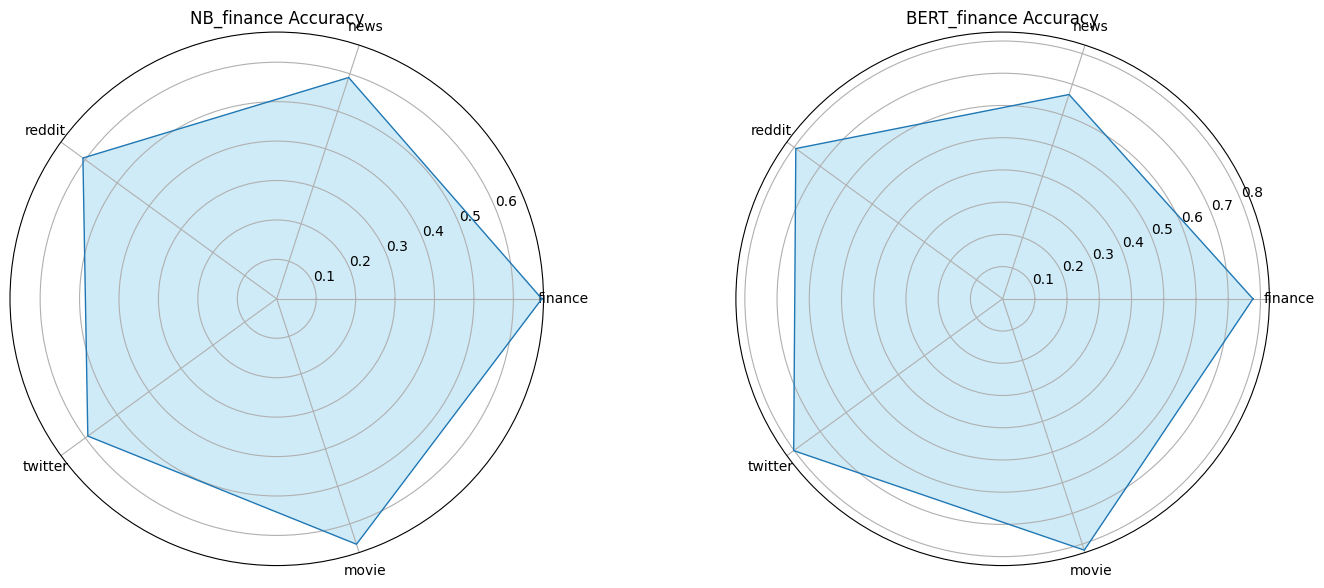

In [32]:
# prompt: I would like to have a diamond graph. So lets take NB_finance for example. Calculate the percentage of correct classifications for each topic and in a diamond chart with 5 corners (labeled after each topic) show the accuracy achieved for predictions in teh given topic. Perfect, can you do the same for BERT_finance and display the two charts next to each other on one fig?

import matplotlib.pyplot as plt
import numpy as np

def calculate_accuracy(predictions, actual):
    correct_predictions = np.sum(np.array(predictions) == np.array(actual))
    return correct_predictions / len(actual)

def create_diamond_chart(ax, model_name, topic_accuracies):
    topics = list(topic_accuracies.keys())
    accuracies = list(topic_accuracies.values())

    angles = np.linspace(0, 2 * np.pi, len(topics), endpoint=False).tolist()
    values = accuracies + [accuracies[0]]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'skyblue', alpha=0.4)
    ax.set_thetagrids(np.degrees(angles[:-1]), topics)

    ax.set_title(f"{model_name} Accuracy")
    ax.grid(True)


# Calculate accuracies for NB_finance
nb_finance_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic][f"NB_{topic.lower().replace(' ', '_')}"].tolist()
    nb_finance_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)


# Calculate accuracies for BERT_finance
bert_finance_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic][f"BERT_{topic.lower().replace(' ', '_')}"].tolist()
    bert_finance_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'polar': True})


# Create the diamond chart for NB_finance
create_diamond_chart(ax1, "NB_finance", nb_finance_topic_accuracies)

# Create the diamond chart for BERT_finance
create_diamond_chart(ax2, "BERT_finance", bert_finance_topic_accuracies)

plt.tight_layout()
plt.show()


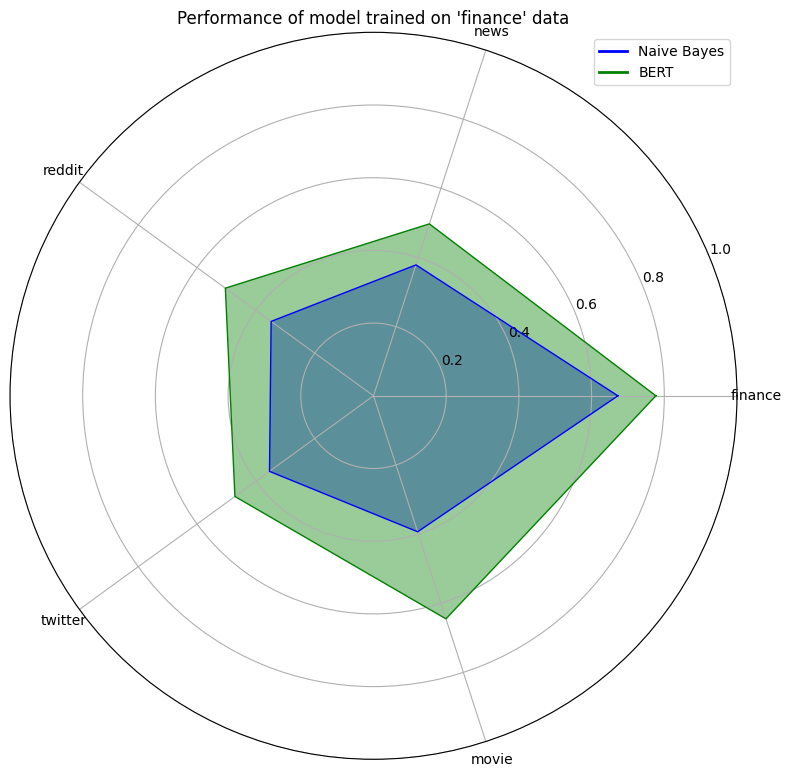

In [45]:

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def create_diamond_chart(ax, model_name, topic_accuracies, color):
    topics = list(topic_accuracies.keys())
    accuracies = list(topic_accuracies.values())

    angles = np.linspace(0, 2 * np.pi, len(topics), endpoint=False).tolist()
    values = accuracies + [accuracies[0]]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1, linestyle='solid', color=color)
    ax.fill(angles, values, color, alpha=0.4)
    ax.set_thetagrids(np.degrees(angles[:-1]), topics)
    ax.set_rlim(0,1)

    ax.set_title(f"Performance of model trained on 'finance' data")
    ax.grid(True)


# Assuming all_preds_subsets DataFrame is already available

# Calculate accuracies for NB_finance
nb_finance_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["NB_finance"].tolist()
    nb_finance_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)


# Calculate accuracies for BERT_finance
bert_finance_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["BERT_finance"].tolist()
    bert_finance_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})

# Plot NB_finance data
create_diamond_chart(ax, "NB_finance", nb_finance_topic_accuracies, "blue")

# Plot BERT_finance data
create_diamond_chart(ax, "BERT_finance", bert_finance_topic_accuracies, "green")


# Add legend
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Naive Bayes'),
    Line2D([0], [0], color='green', lw=2, label='BERT')
]
#ax.legend(["Naive Bayes", "BERT"], loc="upper right")
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.savefig('/content/drive/My Drive/BA THESIS/analysis/performance_finance.png')
plt.show()


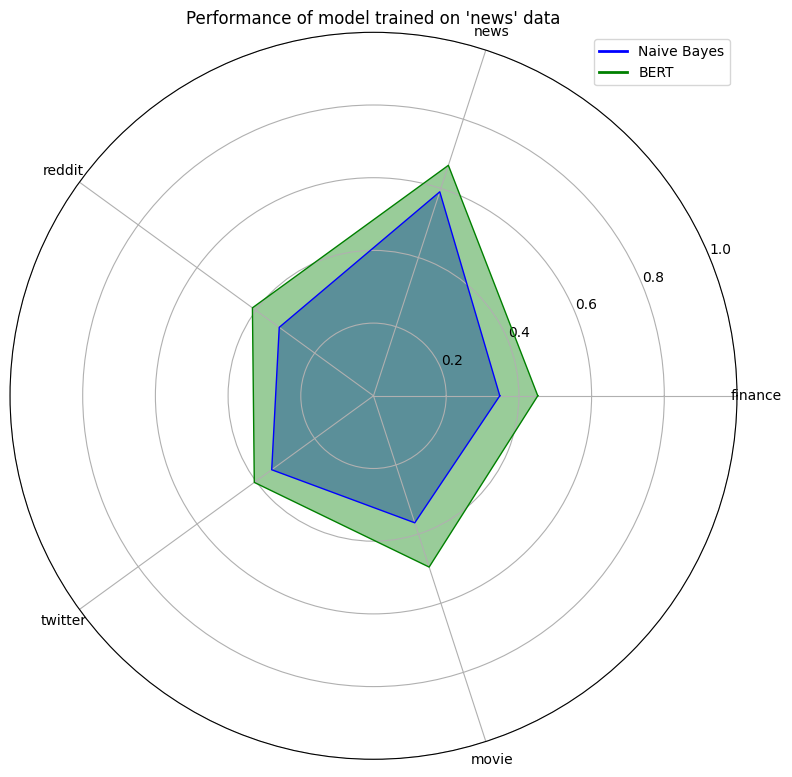

In [46]:
def create_diamond_chart(ax, model_name, topic_accuracies, color):
    topics = list(topic_accuracies.keys())
    accuracies = list(topic_accuracies.values())

    angles = np.linspace(0, 2 * np.pi, len(topics), endpoint=False).tolist()
    values = accuracies + [accuracies[0]]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1, linestyle='solid', color=color)
    ax.fill(angles, values, color, alpha=0.4)
    ax.set_thetagrids(np.degrees(angles[:-1]), topics)
    ax.set_rlim(0,1)

    ax.set_title(f"Performance of model trained on 'news' data")
    ax.grid(True)


# Assuming all_preds_subsets DataFrame is already available

# Calculate accuracies for NB_news
nb_news_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["NB_news"].tolist()
    nb_news_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)


# Calculate accuracies for BERT_news
bert_news_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["BERT_news"].tolist()
    bert_news_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})

# Plot NB_news data
create_diamond_chart(ax, "NB_news", nb_news_topic_accuracies, "blue")

# Plot BERT_news data
create_diamond_chart(ax, "BERT_news", bert_news_topic_accuracies, "green")


# Add legend
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Naive Bayes'),
    Line2D([0], [0], color='green', lw=2, label='BERT')
]
#ax.legend(["Naive Bayes", "BERT"], loc="upper right")
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.savefig('/content/drive/My Drive/BA THESIS/analysis/performance_news.png')
plt.show()

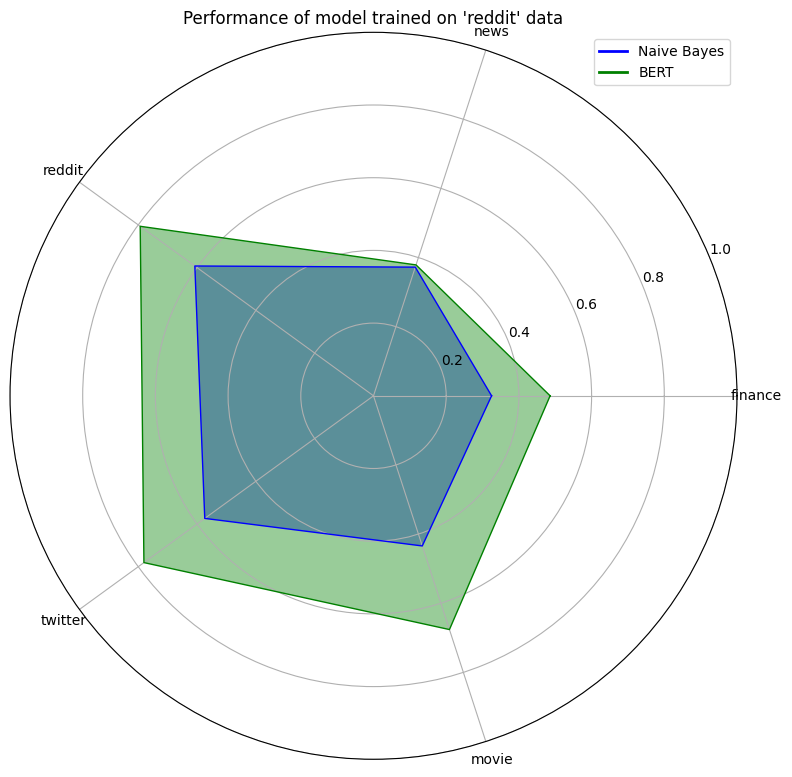

In [47]:
def create_diamond_chart(ax, model_name, topic_accuracies, color):
    topics = list(topic_accuracies.keys())
    accuracies = list(topic_accuracies.values())

    angles = np.linspace(0, 2 * np.pi, len(topics), endpoint=False).tolist()
    values = accuracies + [accuracies[0]]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1, linestyle='solid', color=color)
    ax.fill(angles, values, color, alpha=0.4)
    ax.set_thetagrids(np.degrees(angles[:-1]), topics)
    ax.set_rlim(0,1)

    ax.set_title(f"Performance of model trained on 'reddit' data")
    ax.grid(True)


# Assuming all_preds_subsets DataFrame is already available

# Calculate accuracies for NB_reddit
nb_reddit_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["NB_reddit"].tolist()
    nb_reddit_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)


# Calculate accuracies for BERT_reddit
bert_reddit_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["BERT_reddit"].tolist()
    bert_reddit_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})

# Plot NB_reddit data
create_diamond_chart(ax, "NB_reddit", nb_reddit_topic_accuracies, "blue")

# Plot BERT_reddit data
create_diamond_chart(ax, "BERT_reddit", bert_reddit_topic_accuracies, "green")


# Add legend
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Naive Bayes'),
    Line2D([0], [0], color='green', lw=2, label='BERT')
]
#ax.legend(["Naive Bayes", "BERT"], loc="upper right")
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.savefig('/content/drive/My Drive/BA THESIS/analysis/performance_reddit.png')
plt.show()

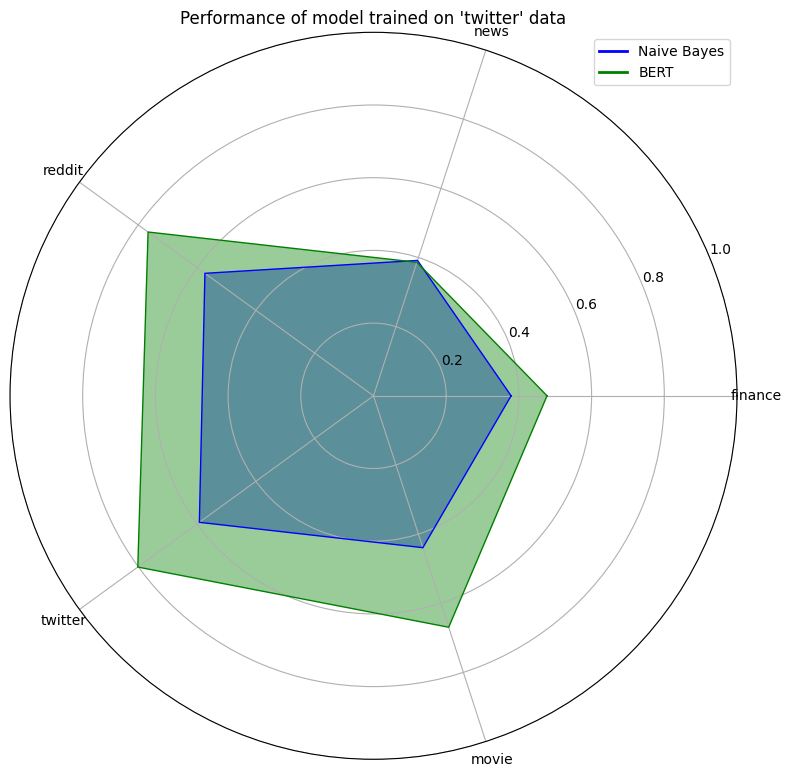

In [48]:
def create_diamond_chart(ax, model_name, topic_accuracies, color):
    topics = list(topic_accuracies.keys())
    accuracies = list(topic_accuracies.values())

    angles = np.linspace(0, 2 * np.pi, len(topics), endpoint=False).tolist()
    values = accuracies + [accuracies[0]]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1, linestyle='solid', color=color)
    ax.fill(angles, values, color, alpha=0.4)
    ax.set_thetagrids(np.degrees(angles[:-1]), topics)
    ax.set_rlim(0,1)

    ax.set_title(f"Performance of model trained on 'twitter' data")
    ax.grid(True)


# Assuming all_preds_subsets DataFrame is already available

# Calculate accuracies for NB_twitter
nb_twitter_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["NB_twitter"].tolist()
    nb_twitter_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)


# Calculate accuracies for BERT_twitter
bert_twitter_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["BERT_twitter"].tolist()
    bert_twitter_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})

# Plot NB_twitter data
create_diamond_chart(ax, "NB_twitter", nb_twitter_topic_accuracies, "blue")

# Plot BERT_twitter data
create_diamond_chart(ax, "BERT_twitter", bert_twitter_topic_accuracies, "green")


# Add legend
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Naive Bayes'),
    Line2D([0], [0], color='green', lw=2, label='BERT')
]
#ax.legend(["Naive Bayes", "BERT"], loc="upper right")
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.savefig('/content/drive/My Drive/BA THESIS/analysis/performance_twitter.png')
plt.show()

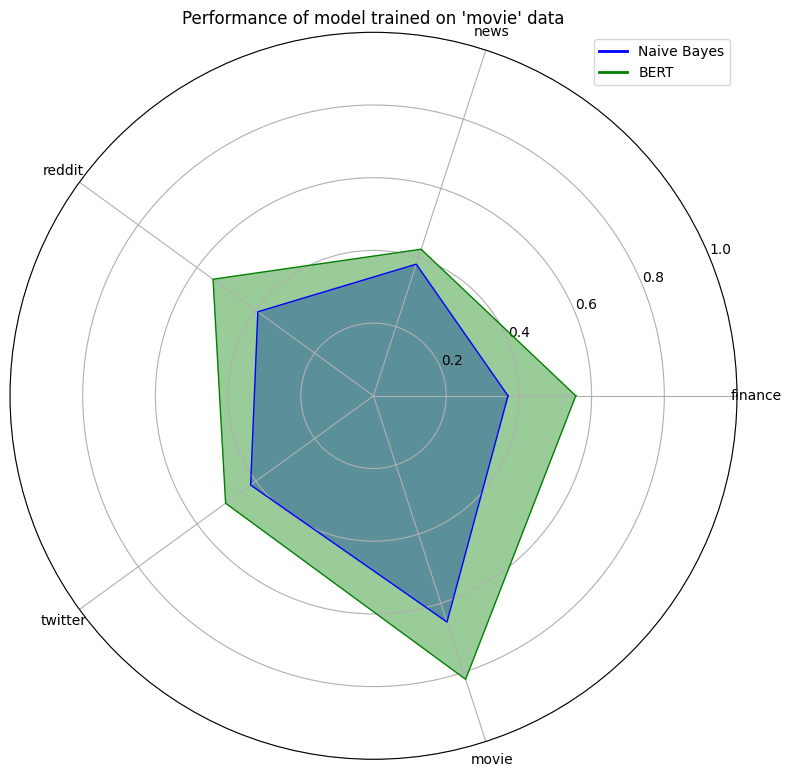

In [49]:
def create_diamond_chart(ax, model_name, topic_accuracies, color):
    topics = list(topic_accuracies.keys())
    accuracies = list(topic_accuracies.values())

    angles = np.linspace(0, 2 * np.pi, len(topics), endpoint=False).tolist()
    values = accuracies + [accuracies[0]]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1, linestyle='solid', color=color)
    ax.fill(angles, values, color, alpha=0.4)
    ax.set_thetagrids(np.degrees(angles[:-1]), topics)
    ax.set_rlim(0,1)

    ax.set_title(f"Performance of model trained on 'movie' data")
    ax.grid(True)


# Assuming all_preds_subsets DataFrame is already available

# Calculate accuracies for NB_movie
nb_movie_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["NB_movie"].tolist()
    nb_movie_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)


# Calculate accuracies for BERT_movie
bert_movie_topic_accuracies = {}
for topic in ["finance", "news", "reddit", "twitter", "movie"]:
    actual_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["Actual"].tolist()
    predicted_labels = all_preds_subsets[all_preds_subsets["Topic"] == topic]["BERT_movie"].tolist()
    bert_movie_topic_accuracies[topic] = calculate_accuracy(predicted_labels, actual_labels)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})

# Plot NB_movie data
create_diamond_chart(ax, "NB_movie", nb_movie_topic_accuracies, "blue")

# Plot BERT_movie data
create_diamond_chart(ax, "BERT_movie", bert_movie_topic_accuracies, "green")


# Add legend
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Naive Bayes'),
    Line2D([0], [0], color='green', lw=2, label='BERT')
]
#ax.legend(["Naive Bayes", "BERT"], loc="upper right")
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.savefig('/content/drive/My Drive/BA THESIS/analysis/performance_movie.png')
plt.show()